# 子类API实现wide&deep

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)



.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test=train_test_split(housing.data, housing.target,random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all,y_train_all,random_state=11)

In [4]:
from sklearn.preprocessing import StandardScaler
transfer = StandardScaler()
x_train_scaled = transfer.fit_transform(x_train)
x_test_scaled = transfer.transform(x_test)
x_valid_scaled = transfer.transform(x_valid)

In [13]:
#子类API
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super().__init__()
        """定义模型层次"""
        self.hidden1_layer = keras.layers.Dense(30,activation='relu')
        self.hidden2_layer = keras.layers.Dense(30,activation='relu')
        self.output_layer= keras.layers.Dense(1)
        
    def call(self, input):
        """完成模型正向计算"""
        hidden1=self.hidden1_layer(input)
        hidden2= self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output= self.output_layer(concat)
        return output
model = WideDeepModel()
model.build(input_shape=(None,8))

model.compile(loss='mean_squared_error',
             optimizer = 'nadam',# SGD -> SGDM -> NAG ->AdaGrad -> AdaDelta -> Adam -> Nadam
             )


In [14]:
model.layers#查看模型层数

In [15]:
model.summary()#d 模型参数

Model: "wide_deep_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [16]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = model.fit(x_train_scaled,y_train,epochs=100,
                   validation_data=(x_valid_scaled,y_valid),
                   callbacks= callbacks 
                   )
#validation_data:训练过程中在验证集验证

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 6s 479us/sample - loss: 1.2656 - val_loss: 0.6327
Epoch 2/100
11610/11610 [==============================] - 2s 201us/sample - loss: 0.4910 - val_loss: 0.4581
Epoch 3/100
11610/11610 [==============================] - 2s 202us/sample - loss: 0.4074 - val_loss: 0.4177
Epoch 4/100
11610/11610 [==============================] - 2s 213us/sample - loss: 0.3907 - val_loss: 0.4033
Epoch 5/100
11610/11610 [==============================] - 2s 213us/sample - loss: 0.3998 - val_loss: 0.3770
Epoch 6/100
11610/11610 [==============================] - 2s 201us/sample - loss: 0.3736 - val_loss: 0.3897
Epoch 7/100
11610/11610 [==============================] - 2s 202us/sample - loss: 0.3525 - val_loss: 0.3552
Epoch 8/100
11610/11610 [==============================] - 2s 201us/sample - loss: 0.3415 - val_loss: 0.3506
Epoch 9/100
11610/11610 [==============================] - 2s 202us/sample - lo

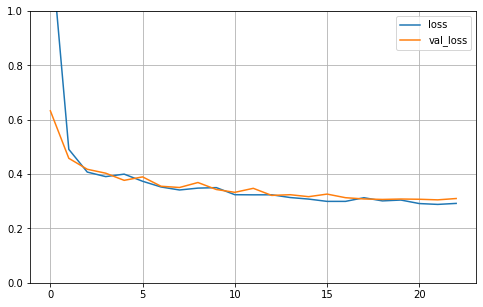

In [17]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [19]:
model.evaluate(x_test_scaled,y_test,verbose=2)

5160/1 - 0s - loss: 0.4257


0.314736437058264